# Contextual Bandits for Ranking with TF-Agents

> see [ranking tutorial](https://www.tensorflow.org/agents/tutorials/ranking_tutorial)

### Overview

* The contextual bandits approach is classified as an extension of multi-armed bandits
* a contextual multi-armed banded problem is a simplified reinforcement learning algorithm where the agent takes an action from a set of possible actions 

> **TODO**

The **Bandit Ranking** agent will be similar to the `NeuralEpsilonGreedy` agent. Main differences:

* The item features are stored in the `per_arm` part of the observation, in the order of how they are recommended
* Since this ordered list of items expresses what action was taken by the policy,
the `action` value of the trajectory is not used by the agent.

> Note: difference between the "per-arm" observation recieved by the policy vs the agent:

While the agent receives the items in the recommendation slots, the policy receives the items that are available for recommendation. The user is responsible for converting the observation to the
syntax required by the agent.


The training observation contains the global features and the features of the items in the recommendation slots 
* The item features are stored in the `per_arm` part of the observation, in the order of how they are recommended
* Note: since this ordered list of items expresses what action was taken by the policy, the action value of the trajectory is not used by the agent

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

## imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
!pwd

/home/jupyter/tf_vertex_agents/03-ranking


In [5]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar, Iterable, Tuple
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl
import pandas as pd

from tqdm import tqdm

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
# from tf_agents.agents import TFAgent

# from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.environments.ranking_environment import FeedbackModel
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
# from tf_agents.drivers import dynamic_step_driver
# from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

# from tf_agents.bandits.agents import lin_ucb_agent
# from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network
from tf_agents.bandits.policies import policy_utilities

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory
from tf_agents.bandits.environments import ranking_environment
from tf_agents.bandits.agents import ranking_agent

from tf_agents.utils import nest_utils
from tf_agents.specs import array_spec

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.utils import train_utils
from src.data import data_utils, data_config

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [9]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

In [10]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

MAX_LIST_LENGTH = 3

def get_all_lw_features(MAX_LIST_LENGTH):
    '''
    listwise features
    '''
    feats = {
        'user_id': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        "movie_id": tf.io.FixedLenFeature(dtype=tf.string, shape=(MAX_LIST_LENGTH,)), 
        "movie_genres": tf.io.FixedLenFeature(dtype=tf.int64, shape=(MAX_LIST_LENGTH,)), 
        "user_rating": tf.io.FixedLenFeature(dtype=tf.float32, shape=(MAX_LIST_LENGTH,))
    }
    return feats

def parse_lw_tfrecord(example):
    """
    Reads a serialized example from GCS and converts to tfrecord
    """
    feats = get_all_lw_features(MAX_LIST_LENGTH)
    
    # example = tf.io.parse_single_example(
    example = tf.io.parse_example(
        example,
        feats
        # features=feats
    )
    return example

In [11]:
# 3 | 5
NUM_EXAMPLES_PER_LIST = MAX_LIST_LENGTH

# SPLIT = "val"
# SPLIT = "listwise-val"
SPLIT = f"listwise-{NUM_EXAMPLES_PER_LIST}n-val"

print(f"SPLIT: {SPLIT}")

SPLIT: listwise-3n-val


In [12]:
! gsutil ls $BUCKET_URI/$DATA_GCS_PREFIX/$SPLIT/

gs://rec-bandits-v2-hybrid-vertex-bucket/data/listwise-3n-val/ml-100k-listwise-3n-val.tfrecord


### Val

In [13]:
# SPLIT = "val"
# SPLIT = "listwise-val"
SPLIT = f"listwise-{NUM_EXAMPLES_PER_LIST}n-val"

val_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        val_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
val_dataset = tf.data.TFRecordDataset(val_files)
val_dataset = val_dataset.map(parse_lw_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

for example in val_dataset.take(1):
    pprint(example)

{'movie_genres': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 0, 0])>,
 'movie_id': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'94', b'245', b'403'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'346'>,
 'user_rating': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 4., 3.], dtype=float32)>}


### Train

In [14]:
# SPLIT = "train"
# SPLIT = "listwise-train"
# SPLIT = f"listwise-{NUM_EXAMPLES_PER_LIST}n-train"

# train_files = []
# for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
#     if '.tfrecord' in blob.name:
#         train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
# train_dataset = tf.data.TFRecordDataset(train_files)
# train_dataset = train_dataset.map(data_utils.parse_lw_tfrecord)

# for x in train_dataset.batch(1).take(1):
#     pprint(x)

In [15]:
train_dataset = val_dataset

### Vocab

In [16]:
GENERATE_VOCABS = False

print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

GENERATE_VOCABS: False


In [17]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'

!gsutil cp gs://mabv1-hybrid-vertex-bucket/vocabs/vocab_dict.pkl $EXISTING_VOCAB_FILE

Copying gs://mabv1-hybrid-vertex-bucket/vocabs/vocab_dict.pkl [Content-Type=application/octet-stream]...
/ [1 files][142.9 KiB/142.9 KiB]                                                
Operation completed over 1 objects/142.9 KiB.                                    


In [18]:
data_utils.download_blob(
    project_id = PROJECT_ID,
    bucket_name = BUCKET_NAME, 
    source_blob_name = f"{VOCAB_SUBDIR}/{VOCAB_FILENAME}", 
    destination_file_name= VOCAB_FILENAME
)

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

for key in vocab_dict.keys():
    pprint(key)

Downloaded storage object vocabs/vocab_dict.pkl from bucket rec-bandits-v2-hybrid-vertex-bucket to local file vocab_dict.pkl.
'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


# Global & Per-Arm feature embedding models 

In [19]:
NUM_OOV_BUCKETS       = 2
GLOBAL_EMBEDDING_SIZE = 64 #64
MV_EMBEDDING_SIZE     = 32 #32

BATCH_SIZE            = 5 #128
EVAL_BATCH_SIZE       = 1

NUM_ITEMS             = NUM_EXAMPLES_PER_LIST # 3 | 5 
NUM_SLOTS             = 2

DISTANCE_THRESHOLD    = 0.5

print(f"NUM_OOV_BUCKETS    : {NUM_OOV_BUCKETS}")
print(f"GLOBAL_EMB_SIZE    : {GLOBAL_EMBEDDING_SIZE}")
print(f"MV_EMB_SIZE        : {MV_EMBEDDING_SIZE}")
print(f"BATCH_SIZE         : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE    : {EVAL_BATCH_SIZE}")
print(f"NUM_ITEMS          : {NUM_ITEMS}")
print(f"NUM_SLOTS          : {NUM_SLOTS}")
print(f"DISTANCE_THRESHOLD : {DISTANCE_THRESHOLD}")

NUM_OOV_BUCKETS    : 2
GLOBAL_EMB_SIZE    : 64
MV_EMB_SIZE        : 32
BATCH_SIZE         : 5
EVAL_BATCH_SIZE    : 1
NUM_ITEMS          : 3
NUM_SLOTS          : 2
DISTANCE_THRESHOLD : 0.5


In [20]:
for i in range(1):
    
    iterator = iter(train_dataset.batch(2))
    data = next(iterator)

data

{'movie_genres': <tf.Tensor: shape=(2, 3), dtype=int64, numpy=
 array([[3, 0, 0],
        [7, 0, 0]])>,
 'movie_id': <tf.Tensor: shape=(2, 3), dtype=string, numpy=
 array([[b'94', b'245', b'403'],
        [b'678', b'127', b'343']], dtype=object)>,
 'user_id': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'346', b'602'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[3., 4., 3.],
        [4., 5., 2.]], dtype=float32)>}

## Embedding layers

#### User ID

In [21]:
user_id_input_layer = tf.keras.Input(
    name="user_id",
    shape=(1,),
    dtype=tf.string
)

user_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_id'],
)(user_id_input_layer)

user_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_id_lookup)

user_id_embedding = tf.reduce_sum(user_id_embedding, axis=-2)

In [22]:
test_user_id_model = tf.keras.Model(inputs=user_id_input_layer, outputs=user_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_id"])
    print(test_user_id_model(x["user_id"]))

tf.Tensor([b'346'], shape=(1,), dtype=string)
tf.Tensor(
[[-0.04060321 -0.01655465 -0.013512   -0.01588846  0.01201389 -0.01844791
  -0.03626658  0.00394806  0.04651405 -0.04853141 -0.00966315 -0.03933873
   0.0269871   0.04153986 -0.01484632 -0.04931954  0.01870462  0.02610353
  -0.03695767 -0.00339975  0.03006348 -0.00055307  0.01057228  0.02693157
  -0.02072923 -0.02094797 -0.01204436  0.02553106  0.04389599  0.01274185
   0.01623205 -0.04331223  0.01707685 -0.04395906 -0.04691389 -0.04004325
   0.03547789  0.02261453 -0.02054854  0.04166413 -0.03763374  0.00970464
   0.00697171  0.03652561  0.03390005 -0.02980416  0.00745809  0.00123277
  -0.02763804  0.04796367 -0.04169714  0.02442802 -0.04594627  0.01083803
  -0.03641246 -0.02538355 -0.03818608  0.00983963  0.02764695  0.01996979
   0.01099852  0.0468596  -0.02501249 -0.03903406]], shape=(1, 64), dtype=float32)


#### Movie ID

In [23]:
# len(vocab_dict['movie_id'])

In [24]:
mv_id_input_layer = tf.keras.Input(
    name="movie_id",
    shape=(1,),
    dtype=tf.string
)

mv_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['movie_id'],
)(mv_id_input_layer)

mv_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_id_lookup)

# mv_id_embedding = tf.reduce_sum(mv_id_embedding, axis=-2)

In [25]:
test_mv_id_model = tf.keras.Model(inputs=mv_id_input_layer, outputs=mv_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_id"])
    list_length = x["movie_id"].shape[1]
    print(test_mv_id_model(x["movie_id"]))

tf.Tensor([[b'94' b'245' b'403']], shape=(1, 3), dtype=string)
tf.Tensor(
[[[-0.00550125  0.04508681 -0.01101776 -0.02124425 -0.03821179
   -0.04999049 -0.04950333  0.04533776  0.04766313  0.02385047
    0.01145978 -0.02199166 -0.04791831 -0.03037078  0.01486554
   -0.01937258  0.02510489  0.02750975  0.02617743  0.01489239
   -0.011874    0.00220197 -0.00374115 -0.02660939  0.01584618
   -0.03366101 -0.00043065 -0.03346916 -0.0247119  -0.00525386
    0.03158767 -0.02280638]
  [-0.00897503 -0.00727518  0.01143936 -0.03420898  0.03010663
    0.01368104  0.04747229 -0.04197438 -0.03019835 -0.03499292
   -0.00029786 -0.0021824  -0.03477731  0.02611     0.01024071
   -0.02102232  0.00052661 -0.04763191 -0.04789667 -0.04680897
   -0.00919986 -0.01765344 -0.04033849  0.01225144  0.024659
   -0.01305405  0.01440387  0.04649707  0.04113059 -0.04577768
   -0.03910523 -0.03110167]
  [ 0.01260752  0.0032235  -0.02442534  0.03770136  0.04929182
    0.04388699  0.0407583  -0.00737512 -0.04598884 -0

#### Movie Genres

In [26]:
# len(vocab_dict['movie_genres'])

In [27]:
mv_genre_input_layer = tf.keras.Input(
    name="movie_genres",
    shape=(1,),
    dtype=tf.float32
)

mv_genre_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_genres'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(mv_genre_input_layer)

mv_genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_genres']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_genre_lookup)

# mv_genre_embedding = tf.reduce_sum(mv_genre_embedding, axis=-2)

In [28]:
test_mv_gen_model = tf.keras.Model(inputs=mv_genre_input_layer, outputs=mv_genre_embedding)

for x in train_dataset.batch(2).take(1):
    print(x["movie_genres"])
    print(test_mv_gen_model(x["movie_genres"]))

tf.Tensor(
[[3 0 0]
 [7 0 0]], shape=(2, 3), dtype=int64)
tf.Tensor(
[[[-0.02387483 -0.01094604 -0.03073199  0.01453476 -0.02907463
    0.0494186  -0.03536667 -0.02610589 -0.01514065  0.01573828
    0.02282779  0.01102275 -0.0018098   0.03573176  0.00916896
    0.02328921 -0.01495224 -0.00705608  0.00275165  0.04925189
    0.0143618  -0.01831417 -0.03787997  0.02609415  0.04274878
    0.02646365  0.03383193 -0.0092683  -0.03662746 -0.01975822
    0.03119681  0.02847514]
  [-0.02346635 -0.04966192 -0.00128305 -0.01283627  0.02176699
   -0.02031562 -0.0348658   0.02050615 -0.03254505 -0.0074871
   -0.04561358  0.0476375  -0.01517812  0.03772027 -0.0335598
    0.00396391 -0.04924505 -0.02025696  0.02334091  0.04911682
   -0.03460226  0.03596878  0.01169761 -0.00945803  0.04790508
   -0.00274339 -0.04168537  0.03609477 -0.02004907 -0.01119034
   -0.03674506  0.02750831]
  [-0.02346635 -0.04966192 -0.00128305 -0.01283627  0.02176699
   -0.02031562 -0.0348658   0.02050615 -0.03254505 -0.0074

## Sampling Functions

#### item sampling

In [29]:
def _get_per_arm_features(x):
    """
    This function generates a single per-arm observation vector.
    """
    ratings_list = x["user_rating"] #[0]
    indices = tf.argsort(ratings_list, direction="DESCENDING")
    _batch_size = len(ratings_list)
    
    mv_ids = test_mv_id_model(x["movie_id"])
    mv_gens = test_mv_gen_model(x["movie_genres"])
    
    concat_embeddings = tf.concat(
        [mv_ids, mv_gens], axis=-1
    )
    
    ordered_concat = tf.gather(concat_embeddings, indices, batch_dims=1)
    # feedback = tf.gather_nd(concat_embeddings, indices)
    # print(f"ordered_concat_embeddings: {ordered_concat_embeddings}")
    # ordered_concat = tf.reduce_sum(ordered_concat, axis=0)
    
    slotted_ordered_concat = tf.slice(
        ordered_concat, begin=[0, 0, 0], size=[_batch_size, NUM_SLOTS, MV_EMBEDDING_SIZE * NUM_SLOTS]
    )
    
    return slotted_ordered_concat

In [30]:
test_arms = _get_per_arm_features(data)
test_arms #.shape

<tf.Tensor: shape=(2, 2, 64), dtype=float32, numpy=
array([[[-0.00897503, -0.00727518,  0.01143936, -0.03420898,
          0.03010663,  0.01368104,  0.04747229, -0.04197438,
         -0.03019835, -0.03499292, -0.00029786, -0.0021824 ,
         -0.03477731,  0.02611   ,  0.01024071, -0.02102232,
          0.00052661, -0.04763191, -0.04789667, -0.04680897,
         -0.00919986, -0.01765344, -0.04033849,  0.01225144,
          0.024659  , -0.01305405,  0.01440387,  0.04649707,
          0.04113059, -0.04577768, -0.03910523, -0.03110167,
         -0.02346635, -0.04966192, -0.00128305, -0.01283627,
          0.02176699, -0.02031562, -0.0348658 ,  0.02050615,
         -0.03254505, -0.0074871 , -0.04561358,  0.0476375 ,
         -0.01517812,  0.03772027, -0.0335598 ,  0.00396391,
         -0.04924505, -0.02025696,  0.02334091,  0.04911682,
         -0.03460226,  0.03596878,  0.01169761, -0.00945803,
          0.04790508, -0.00274339, -0.04168537,  0.03609477,
         -0.02004907, -0.01119034

In [31]:
test_arms = _get_per_arm_features(data)

PER_ARM_DIM = test_arms.shape[2]            
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

# test_arms

PER_ARM_DIM: 64


#### global sampling

In [32]:
def _get_global_context_features(x):
    """
    This function generates a single global observation vector.
    """
    
    return test_user_id_model(x['user_id'])

In [33]:
test_globals = _get_global_context_features(data)

GLOBAL_DIM = test_globals.shape[1] 
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

# test_globals

GLOBAL_DIM: 64


# Ranking Agent

## Feedback type

Ranking agents assume either a `score_vector` or `cascading feedback` framework for the feedback signal (reward). 

* `score_vector`: feedback is a vector of scores for every item in the slots. 
* `cascading feedback`: if the kth item was clicked, then the items up to k-1 receive a score of -1, the kth item receives a score based on a feedback value, while the rest of the items receive feedback of 0. 

Ranking agent objective: train the scoring network to be able to estimate the above scores

In [34]:
# feedback_model = ranking_environment.FeedbackModel.CASCADING
feedback_model = FeedbackModel.SCORE_VECTOR

## Tensor Specs

example Tensor Spec structures...

`observation_spec()`

```python
{'global': TensorSpec(shape=(9,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(50, 11), dtype=tf.float32, name=None)}
```

`action_spec()`

```python
BoundedTensorSpec(shape=(3,), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(49, dtype=int32))
```

`reward_spec()`

```python
{'chosen_index': BoundedTensorSpec(shape=(), dtype=tf.int32, name='chosen_index', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32)),
 'chosen_value': TensorSpec(shape=(), dtype=tf.float32, name='chosen_value')}
```

`time_step_spec()`

```python
TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(9,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(50, 11), dtype=tf.float32, name=None)},
 'reward': {'chosen_index': BoundedTensorSpec(shape=(), dtype=tf.int32, name='chosen_index', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32)),
            'chosen_value': TensorSpec(shape=(), dtype=tf.float32, name='chosen_value')},
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
```

**from [ranking_environment.py](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/ranking_environment.py#L152C1-L166C6)**

```
    global_spec = array_spec.ArraySpec.from_array(global_sampling_fn())
    item_spec = array_spec.add_outer_dims_nest(
        array_spec.ArraySpec.from_array(item_sampling_fn()), (num_items,)
    )
    observation_spec = {GLOBAL_KEY: global_spec, PER_ARM_KEY: item_spec}
    self._global_dim = global_spec.shape[0]
    self._item_dim = item_spec.shape[-1]

    action_spec = array_spec.BoundedArraySpec(
        shape=(num_slots,),
        dtype=np.int32,
        minimum=0,
        maximum=num_items - 1,
        name='action',
    )
```

set vars

In [35]:
from tf_agents.specs import array_spec

print(f"BATCH_SIZE         : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE    : {EVAL_BATCH_SIZE}")
print(f"NUM_ITEMS          : {NUM_ITEMS}")
print(f"NUM_SLOTS          : {NUM_SLOTS}")
print(f"DISTANCE_THRESHOLD : {DISTANCE_THRESHOLD}")
print(f"GLOBAL_DIM         : {GLOBAL_DIM}")
print(f"PER_ARM_DIM        : {PER_ARM_DIM}")

BATCH_SIZE         : 5
EVAL_BATCH_SIZE    : 1
NUM_ITEMS          : 3
NUM_SLOTS          : 2
DISTANCE_THRESHOLD : 0.5
GLOBAL_DIM         : 64
PER_ARM_DIM        : 64


### Observation spec

* The observation the agent ingests contains the global features and the features
of the items in the recommendation slots. 
* The item features are stored in the `per_arm` part of the observation, in the order of how they are recommended.
* Since this ordered list of items expresses what action was taken by the policy, the `action` value of the trajectory is not used by the agent.

In [36]:
observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    # 'per_arm': tf.TensorSpec([NUM_ITEMS, PER_ARM_DIM], tf.float32)
    'per_arm': tf.TensorSpec([NUM_SLOTS, PER_ARM_DIM], tf.float32)
}
observation_spec

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

### Action spec

> Action spec for ranking models must have rank 1

In [37]:
action_spec = array_spec.BoundedArraySpec(
    shape=(NUM_SLOTS,),
    dtype=np.int32,
    minimum=0,
    maximum=NUM_ITEMS - 1,
    name='action',
)

print(f"action_spec rank: {action_spec.shape}")

action_spec

action_spec rank: (2,)


BoundedArraySpec(shape=(2,), dtype=dtype('int32'), name='action', minimum=0, maximum=2)

### Reward spec

In [38]:
if feedback_model == ranking_environment.FeedbackModel.CASCADING:
    # `chosen_index == num_slots` means no recommended item was clicked.
    reward_spec = {
        'chosen_index': array_spec.BoundedArraySpec(
            shape=[],
            minimum=0,
            maximum=NUM_SLOTS,
            dtype=np.int32,
            name='chosen_index',
        ),
        'chosen_value': array_spec.ArraySpec(
            shape=[], dtype=np.float32, name='chosen_value'
        ),
    }
elif feedback_model == ranking_environment.FeedbackModel.SCORE_VECTOR:
    reward_spec = tf.TensorSpec(
        shape=[NUM_SLOTS], dtype=np.float32, name='score_vector'
    )
    # reward_spec = array_spec.ArraySpec(
    #     shape=[NUM_SLOTS], dtype=np.float32, name='score_vector'
    # )
else:
    reward_spec = f"Feedback model: {feedback_model}, not implemented"
    
reward_spec

TensorSpec(shape=(2,), dtype=tf.float32, name='score_vector')

### TimeStep spec

In [39]:
# TODO - investigate adding reward_spec
"""
TypeError: Expected observation and reward specs to 
both be either tensor or array specs, but saw spec values 
TensorSpec(shape=(64,), dtype=tf.float32, name=None) 
vs. ArraySpec(shape=(2,), dtype=dtype('float32'), name='score_vector')
"""


time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    reward_spec = reward_spec             # TODO
)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(2,), dtype=tf.float32, name='score_vector'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

Inspect chosen arm features spec

In [40]:
time_step_spec.observation

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

## Policy and Scoring Network

> all ranking agents train a network that estimates scores of item/user pairs

**Ranking Policies**
* `DESCENDING_SCORES` - Stack rank deterministically by scores
* `NO_PENALTY` - Sampling sequentially based on scores; no penalty applied
* `COSINE_DISTANCE` - Sampling sequentally and taking diversity into account

`penalty_mixture` parameter governs the balance between ranking based on scores and accounting for diversity
* low positive value --> ranking has less diversity
* higher value --> enforces more diversity

`logits_temperature` - temperature parameter for non-deterministic policies
* This value must be positive

In [41]:
print(f"GLOBAL_DIM  : {GLOBAL_DIM}")
print(f"PER_ARM_DIM : {PER_ARM_DIM}")

GLOBAL_DIM  : 64
PER_ARM_DIM : 64


In [42]:
AGENT_TYPE = "Ranking"
NETWORK_TYPE = "dotproduct"
POLICY_TYPE = ranking_agent.RankingPolicyType.DESCENDING_SCORES # COSINE_DISTANCE | NO_PENALTY | DESCENDING_SCORES

PENALTY_MIXTURE = 1.0
LOGITS_TEMPERATURE = 1.0

LEARNING_RATE = 0.005

GLOBAL_LAYERS   = [64, 32, 16]
ARM_LAYERS      = [64, 32, 16]
COMMON_LAYERS   = [16, 8]

HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_items": NUM_ITEMS,
    "num_slots": NUM_SLOTS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LEARNING_RATE,
    "policy_type": POLICY_TYPE,
    "feedback_model" : feedback_model,
    "penalty_mixture": PENALTY_MIXTURE,
    "logits_temperature": LOGITS_TEMPERATURE,
}
pprint(HPARAMS)

{'batch_size': 5,
 'common_layers': [16, 8],
 'eval_batch_size': 1,
 'feedback_model': 2,
 'global_layers': [64, 32, 16],
 'learning_rate': 0.005,
 'logits_temperature': 1.0,
 'model_type': 'Ranking',
 'network_type': 'dotproduct',
 'num_items': 3,
 'num_slots': 2,
 'penalty_mixture': 1.0,
 'per_arm_layers': [64, 32, 16],
 'policy_type': <RankingPolicyType.DESCENDING_SCORES: 3>}


In [43]:
if NETWORK_TYPE == 'commontower':
    scoring_network = global_and_arm_feature_network.create_feed_forward_common_tower_network(
        observation_spec = observation_spec, 
        global_layers = GLOBAL_LAYERS, 
        arm_layers = ARM_LAYERS, 
        common_layers = COMMON_LAYERS,
        # output_dim = output_dim,
    )
    
elif NETWORK_TYPE == 'dotproduct':
    scoring_network = global_and_arm_feature_network.create_feed_forward_dot_product_network(
        observation_spec = observation_spec, 
        global_layers = GLOBAL_LAYERS, 
        arm_layers = ARM_LAYERS
    )
    
if NETWORK_TYPE:
    print(f"Network: {scoring_network.name}")

Network: GlobalAndArmDotProductNetwork


## Define Agent 

In [44]:
rank_agent = ranking_agent.RankingAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    scoring_network=scoring_network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=HPARAMS['learning_rate']),
    feedback_model=ranking_agent.FeedbackModel.SCORE_VECTOR, # FeedbackModel.SCORE_VECTOR, # feedback_model,
    policy_type=HPARAMS['policy_type'],
    logits_temperature=HPARAMS['logits_temperature'],
    penalty_mixture_coefficient=HPARAMS['penalty_mixture'],
    summarize_grads_and_vars=True
)

rank_agent.initialize()

print(f'rank_agent: {rank_agent.name}')

rank_agent: ranking_agent


In [45]:
rank_agent.policy

In [46]:
rank_agent.action_spec

BoundedTensorSpec(shape=(2,), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32))

In [47]:
rank_agent.training_data_spec.observation

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

In [48]:
rank_agent.policy.time_step_spec

_TupleWrapper(TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': DictWrapper({'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}),
 'reward': TensorSpec(shape=(2,), dtype=tf.float32, name='score_vector'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}))

In [49]:
rank_agent.policy.trajectory_spec

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(2,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}),
 'policy_info': PolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()),
 'reward': TensorSpec(shape=(2,), dtype=tf.float32, name='score_vector'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}))

### Reward function

**TODO**
* `_create_ranking_reward_features`
* `_get_rewards_from_arm_features` 

In [50]:
def _get_ranking_rewards_sv(x):
    """Calculates reward for the actions."""
    
    # rating_scores_list = []
    ratings_list = x["user_rating"] #[0]
    indices = tf.argsort(ratings_list, direction="DESCENDING")
    
    feedback = tf.gather(ratings_list, indices, batch_dims=-1) #.numpy()
    
    # feedback = tf.math.top_k(feedback, k=HPARAMS['num_slots']).values
    top_n_ratings = tf.slice(feedback, begin=[0, 0], size=[-1, HPARAMS['num_slots']])
    
    return top_n_ratings

In [51]:
test_ratings = _get_ranking_rewards_sv(data)
test_ratings

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[4., 3.],
       [5., 4.]], dtype=float32)>

In [52]:
def _rank_trajectory_fn(element): # hparams
    """Converts a dataset element into a trajectory."""
    # global_features = _get_global_context_features(element)
    # arm_features = _get_per_arm_features(element)
    
    global_features = _get_global_context_features(element)
    arm_features = _get_per_arm_features(element)
    
    # obs spec
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            train_utils._add_outer_dimension(global_features),
            # global_features,
        bandit_spec_utils.PER_ARM_FEATURE_KEY: 
            train_utils._add_outer_dimension(arm_features)
            # arm_features
    }
    
    # reward = element['user_rating']
    ranking_rewards = _get_ranking_rewards_sv(element)

    
    # action = np.zeros((HPARAMS['num_slots']), dtype=np.int32)
    action=tf.zeros_like(HPARAMS['num_slots'], dtype=tf.int32)
    
    # discount = np.zeros((HPARAMS['num_slots']), dtype=np.float32)
    discount=tf.zeros_like(HPARAMS['num_slots'], dtype=tf.int32)
    return trajectory.single_step(
        observation=observation,
        action=action,
        policy_info=(), #policy_info,
        reward=ranking_rewards,
        discount=discount
    )


In [53]:
for x in train_dataset.batch(HPARAMS['batch_size']).take(1):
    test_traj = _rank_trajectory_fn(x)
    
# test_traj

In [54]:
test_traj

Trajectory(
{'action': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'discount': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'next_step_type': <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 'observation': {'global': <tf.Tensor: shape=(5, 1, 64), dtype=float32, numpy=
array([[[ 3.58744599e-02,  4.06086333e-02,  1.65843479e-02,
          4.88881133e-02, -4.34852950e-02,  2.20158137e-02,
          6.70757145e-03,  4.17699553e-02,  4.56101410e-02,
         -4.14903387e-02,  2.87679546e-02, -2.77934913e-02,
          3.08319665e-02,  2.42299102e-02, -1.30652301e-02,
         -4.69043963e-02,  4.61859964e-02, -4.23259996e-02,
          2.88787819e-02,  1.09393708e-02, -2.39308719e-02,
         -2.42043138e-02,  1.34402514e-03,  4.48107012e-02,
         -4.68876734e-02, -2.27454435e-02, -1.21721737e-02,
          2.64799595e-03,  7.38717616e-04, -4.94922176e-02,
          3.67024876e-02, -4.94284555e-03, -3.14615853e-02,
          2.03740038e-02,  2.00892352e-02,  2.15639137e-02,
          7

In [54]:
print(f"test_traj.observation.shape: {test_traj.observation['global'].shape}")
print(f"test_traj.observation.shape: {test_traj.observation['per_arm'].shape}")
print(f"test_traj.discount.shape   : {test_traj.discount.shape}") 

expected_num_actions = action_spec.maximum - action_spec.minimum + 1
print(f"expected_num_actions: {expected_num_actions}")

predicted_rewards_mean = tensor_spec.TensorSpec([expected_num_actions])
print(f"predicted_rewards_mean: {predicted_rewards_mean}")

test_traj.observation.shape: (5, 1, 64)
test_traj.observation.shape: (5, 1, 2, 64)
test_traj.discount.shape   : ()
expected_num_actions: 3
predicted_rewards_mean: TensorSpec(shape=(3,), dtype=tf.float32, name=None)


# Train Ranking Agent

In [55]:
EXPERIMENT_NAME   = 'new-ranker-v2'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : new-ranker-v2
RUN_NAME          : run-20250124-193034

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/run-20250124-193034
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/run-20250124-193034/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/run-20250124-193034/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/run-20250124-193034/artifacts


In [56]:
import collections

from tf_agents.policies import py_tf_eager_policy
# from tf_agents.policies import tf_policy
# from tf_agents.trajectories import time_step as ts
# from tf_agents.policies import policy_saver
# from tf_agents.metrics import export_utils
from tf_agents.metrics import tf_metrics
# from tf_agents.eval import metric_utils
# from tf_agents.utils import common

import tf_agents

print(f"tf_agents version: {tf_agents.__version__}")
print(f"tensorflow version: {tf.__version__}")

tf_agents version: 0.17.0
tensorflow version: 2.13.0


### logs & checkpoints

In [57]:
global_step = tf.compat.v1.train.get_or_create_global_step()

rank_agent.initialize()
print(f'agent: {rank_agent.name}')
print(f'agent: {rank_agent.policy.name}')

agent: ranking_agent
agent: descending_score_ranking_policy


In [59]:
# ====================================================
# TB summary writer
# ====================================================
train_summary_writer = tf.compat.v2.summary.create_file_writer(
    f"{LOG_DIR}", flush_millis=10 * 1000
)
# train_summary_writer.set_as_default()

# eval_summary_writer = tf.compat.v2.summary.create_file_writer(
#     f"{LOG_DIR}/eval", flush_millis=10 * 1000
# )
# ====================================================
# metrics
# ====================================================
# `step_metric` records the number of individual rounds of bandit interaction;
# that is, (number of trajectories) * batch_size
step_metric = tf_metrics.EnvironmentSteps()

if feedback_model == ranking_environment.FeedbackModel.SCORE_VECTOR:
    reward_metric = tf_metrics.AverageReturnMetric(
        batch_size=HPARAMS['batch_size'],
        buffer_size=20
    )
else:
    reward_metric = tf_metrics.AverageReturnMultiMetric(
        reward_spec=environment.reward_spec(),
        batch_size=HPARAMS['batch_size'],
        buffer_size=20
    )
    
metrics = [reward_metric]

pprint(f"metrics: {metrics}")
# ====================================================
# get checkpoint manager
# ====================================================
print(f"setting checkpoint_manager: {CHECKPT_DIR}\n")

checkpoint_manager = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHECKPT_DIR, 
    agent=rank_agent, 
    metrics=metrics, 
    step_metric=global_step # step_metric
)

('metrics: [<tf_agents.metrics.tf_metrics.AverageReturnMetric object at '
 '0x7f4ff0593f10>]')
setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/chkpoint

Restoring checkpoint from gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/chkpoint/ckpt-50
Successfully restored to step 0


In [60]:
step_metric.result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [61]:
global_step

<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>

#### Saving Ranking Bandits

> Note: [open issue](https://github.com/tensorflow/agents/issues/891) regarding saving ranking bandit models

Until this is resolved, use the `checkpoint_manager` to restore the latest trained policy. 

More on this in the `Inference` section below

In [62]:
# ====================================================
# policy saver
# ====================================================

# saver = policy_saver.PolicySaver(
#     policy = rank_agent.policy, 
#     # train_step=global_step
# )

In [63]:
policy = rank_agent.policy
policy

In [64]:
# len(list(train_dataset))

## Train config

In [65]:
TRAIN_DATA_SIZE = 900          # len(list(train_dataset))
NUM_TRAIN_STEPS = 50            # TRAIN_DATA_SIZE // HPARAMS['batch_size']

EVAL_DATA_SIZE  = 900          # len(list(val_dataset))
NUM_EVAL_STEPS  = 100           # EVAL_DATA_SIZE // HPARAMS['eval_batch_size']

CHKPT_INTERVAL  = NUM_TRAIN_STEPS - 1 # // 5
LOG_INTERVAL    = 10
# EVAL_INTERVAL = NUM_TRAIN_STEPS // 2

print(f"TRAIN_DATA_SIZE : {TRAIN_DATA_SIZE}")
print(f"NUM_TRAIN_STEPS : {NUM_TRAIN_STEPS}")
print(f"EVAL_DATA_SIZE : {EVAL_DATA_SIZE}")
print(f"NUM_EVAL_STEPS : {NUM_EVAL_STEPS}")
print(f"CHKPT_INTERVAL: {CHKPT_INTERVAL}")
print(f"LOG_INTERVAL : {LOG_INTERVAL}")
# print(f"EVAL_INTERVAL : {EVAL_INTERVAL}")

TRAIN_DATA_SIZE : 900
NUM_TRAIN_STEPS : 50
EVAL_DATA_SIZE : 900
NUM_EVAL_STEPS : 100
CHKPT_INTERVAL: 49
LOG_INTERVAL : 10


In [66]:
# train data
train_ds_iterator = iter(train_dataset.batch(HPARAMS['batch_size']))

# eval dataset
eval_ds = val_dataset.batch(HPARAMS["eval_batch_size"])

if NUM_EVAL_STEPS > 0:
    eval_ds = eval_ds.take(NUM_EVAL_STEPS)

[ranking_agent](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/ranking_agent.py#L288C1-L310C8)

```
  def _loss(
      self,
      experience: types.NestedTensor,
      weights: Optional[types.Tensor] = None,
      training: bool = False,
  ) -> tf_agent.LossInfo:
    """Computes loss for training the reward and constraint networks.

    Args:
      experience: A batch of experience data in the form of a `Trajectory` or
        `Transition`.
      weights: Optional scalar or elementwise (per-batch-entry) importance
        weights.  The output batch loss will be scaled by these weights, and the
        final scalar loss is the mean of these values.
      training: Whether the loss is being used for training.

    Returns:
      A `LossInfo` containing the loss for the training step.

    Raises:
      ValueError:
        if the number of actions is greater than 1.
    """
```

In [67]:
# ====================================================
# train setp function
# ====================================================
@tf.function
def _train_step_fn():

    data = next(train_ds_iterator)
    trajectories = _rank_trajectory_fn(data)
    loss = rank_agent.train(experience=trajectories)

    return loss

In [68]:
list_o_loss = []

rank_agent.train_step_counter.assign(0)

print(f"starting train loop...")
start_time = time.time()

for i in range(NUM_TRAIN_STEPS):
    
    with train_summary_writer.as_default():

        step = rank_agent.train_step_counter.numpy()
        
#         data = next(train_ds_iterator)
#         trajectories = _rank_trajectory_fn(data)

#         # All tensors in experience must be shaped [batch, time, ...] 
#         loss = rank_agent.train(experience=trajectories)

        loss = _train_step_fn()
        list_o_loss.append(loss.loss.numpy())
        
        train_utils._export_metrics_and_summaries(
            step=i, 
            metrics=metrics
        )
        
        # print step loss
        if step % LOG_INTERVAL == 0:
            print(
                'step = {0}: train loss = {1}'.format(
                    step, round(loss.loss.numpy(), 2)
                )
            )
            
checkpoint_manager.save(global_step)
print(f"saved to checkpoint_manager: {CHECKPT_DIR}")
runtime_mins = int((time.time() - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

starting train loop...
step = 0: train loss = 1.2100000381469727
step = 10: train loss = 1.690000057220459
step = 20: train loss = 0.7099999785423279
step = 30: train loss = 0.6700000166893005
step = 40: train loss = 1.149999976158142
saved to checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/chkpoint
train runtime_mins: 3


## Evaluate train job

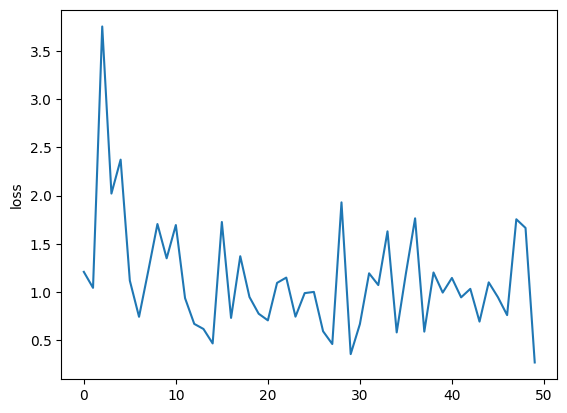

In [69]:
import matplotlib.pyplot as plt

plt.plot(list_o_loss)
# plt.ylim([0, 10])
plt.ylabel('loss')
plt.show()

### TensorBoard


kill orphan TB proccess running on port 6006:

```bash
lsof -i:6006
kill $(lsof -t -i:6006)
```


In [70]:
! gsutil ls $LOG_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/run-20250124-193034/logs/
gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/run-20250124-193034/logs/events.out.tfevents.1737747064.rl-agents-for-recsys-2024.854046.0.v2


In [71]:
# %load_ext tensorboard
%reload_ext tensorboard

In [73]:
# %tensorboard --logdir=$LOG_DIR

## Save Ranking Policy

Unable to save ranking policies: https://github.com/tensorflow/agents/issues/891

In [82]:
# tf.saved_model.save(model, export_dir, signatures=signatures)

# Inference

**Prediction response**
> **TODO:** explain prediction response, e.g., `predicted_rewards_mean=array([3.1828353, 3.6808753]`

In [74]:
deployment_agent = rank_agent.policy
deployment_agent

In [75]:
post_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(deployment_agent, use_tf_function=True)
post_policy_tf

## Get Predictions

To generate an inference request, we need to create a single [TimeStep](https://github.com/tensorflow/agents/blob/master/tf_agents/trajectories/time_step.py#L54C1-L64C3) with the following schema:

```python
class TimeStep(
    NamedTuple(
        'TimeStep',
        [
            ('step_type', types.SpecTensorOrArray),
            ('reward', types.NestedSpecTensorOrArray),
            ('discount', types.SpecTensorOrArray),
            ('observation', types.NestedSpecTensorOrArray),
        ],
    )
):
```
* the `infer_step` below is functionally equivalent to:

```python
prediction = post_policy_tf.action(
    ts.restart(observation, batch_size=HPARAMS['eval_batch_size']), ()
)
```

In [76]:
INFER_SIZE = 1
# dummy_arm = tf.zeros([INFER_SIZE, PER_ARM_DIM], dtype=tf.float32)

SKIP_NUM = 10

for x in eval_ds.skip(SKIP_NUM).take(INFER_SIZE):
    
    # global context features
    global_features = _get_global_context_features(x)
    global_features = tf.reshape(global_features, [GLOBAL_DIM]) # flatten
    
    # TODO: pass   : NUM_ITEMS items to trained policy
    #       return : ranking for NUM_SLOTS
    arm_features = _get_per_arm_features(x)
    arm_feat_infer = tf.reshape(arm_features, [ HPARAMS['num_slots'], HPARAMS['eval_batch_size'], PER_ARM_DIM ]) # perarm_dim
    arm_feat_infer = train_utils._remove_outer_dimension(arm_feat_infer)
    
    # train observation
    observation = {'global': global_features, 'per_arm': arm_feat_infer}
    
    ranking_rewards = _get_ranking_rewards_sv(x)
    
    action = np.zeros((HPARAMS['num_slots']), dtype=np.int32)
    discount = np.zeros((HPARAMS['num_slots']), dtype=np.float32)
    
    infer_step = ts.TimeStep(
        step_type = tf.constant(
            ts.StepType.FIRST, 
            dtype=tf.int32, 
            shape=[],
            name='step_type'
        ),
        reward = ranking_rewards,
        discount = tf.constant(
            1.0, dtype=tf.float32, shape=[], name='discount'
        ),
        observation = observation
    )
    
    prediction = post_policy_tf.action(infer_step)

In [77]:
prediction

PolicyStep(action=array([1, 0], dtype=int32), state=(), info=PolicyInfo(log_probability=(), predicted_rewards_mean=array([3.7947938, 3.8121471], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()))

In [78]:
prediction.action

array([1, 0], dtype=int32)

In [79]:
prediction.info.predicted_rewards_mean

array([3.7947938, 3.8121471], dtype=float32)

#### restart trajectory (?)

In [80]:
prediction = post_policy_tf.action(
    ts.restart(observation, batch_size=HPARAMS['eval_batch_size']), ()
)
prediction

PolicyStep(action=array([1, 0], dtype=int32), state=(), info=PolicyInfo(log_probability=(), predicted_rewards_mean=array([3.7947938, 3.8121471], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()))

## Load a trained Ranking Bandit policy

```
├── chkpt_dir
│   ├── checkpoint
│   │   ├── checkpoint
│   │   ├── ckpt-250.data-00000-of-00001
│   │   ├── ckpt-250.index
│   │   ├── ckpt-50.data-00000-of-00001
│   │   └── ckpt-50.index
```

Here we'll show how to load a trained policy, as you would for a prediction endpoint. You need 3 objects to restore a trained policy from the last checkpoint:
* **agent**: a tf-agents agent object following the same specs used during training
* **metrics**: metrics tracked during training
* **step metric**: `tf_metrics.EnvironmentSteps()` 

Becasue we already have these initialized in this notebook session, we can resuse them here and just pass the root folder of latest checkpoint (e.g., `CHECKPT_DIR`)
* this restores the `agent` object to reflect the checkpointed policy
> Note: when restoring the checkpointed policy in a new environment, we'll need to also initialize the three python objects above

Then, we wrap the loaded policy with [PyTFEagerPolicy()](https://www.tensorflow.org/agents/api_docs/python/tf_agents/policies/PyTFEagerPolicy) to use it in eager mode

In [81]:
!gsutil ls $CHECKPT_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/chkpoint/
gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/chkpoint/checkpoint
gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/chkpoint/ckpt-50.data-00000-of-00001
gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/chkpoint/ckpt-50.index


In [83]:
restore_policy = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHECKPT_DIR, 
    agent=rank_agent, 
    metrics=metrics, 
    step_metric=global_step
)
restore_policy

Restoring checkpoint from gs://rec-bandits-v2-hybrid-vertex-bucket/new-ranker-v2/chkpoint/ckpt-50
Successfully restored to step 50


In [85]:
from tf_agents.policies import py_tf_eager_policy

deployment_agent = rank_agent.policy

post_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(deployment_agent, use_tf_function=True)
post_policy_tf

#### Test inference with restored policy...

In [86]:
pred_test = post_policy_tf.action(
    ts.restart(observation, batch_size=HPARAMS['eval_batch_size']), ()
)
pred_test

PolicyStep(action=array([1, 0], dtype=int32), state=(), info=PolicyInfo(log_probability=(), predicted_rewards_mean=array([3.7947938, 3.8121471], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()))

# Evaluation Loop

> Evaluate the agent's policy after training

**TODOs**
* Need better ranking metric for listwise data
* Latest version of [TF-Ranking](https://github.com/tensorflow/ranking) (`0.5.3`) requires `tensorflow==2.11.0`. Currently using `tensorflow==2.13.0` (consider downgrading?) 

### Sampling rankings

A simple way to produce a ranking is to score each item and sort them by predicted rewards.
* To induce exploration, we could occasionally ignore the predicted reward and produce random lists in an epsilon-greedy manner.

Alternatively, we could produce a score of all the items and use the `Plackett Luce` distribution to sample permutations of the items.
* An implementation exists in `tf-probability`:

```python
scores = [...]
dist = tfd.PlackettLuce(scores)  # Scores have to be non-negative.
sample = dist.sample(...)
# We can also compute sampling probabilities of the ranking
prob = dist.prob(...)
```

In [108]:
def _levenshtein_distance(hypothesis, truth):
    dist_tensor = tf.edit_distance(
        tf.sparse.from_dense(tf.constant(hypothesis, dtype=tf.int32)),
        tf.sparse.from_dense(tf.constant(truth, dtype=tf.int32)),
    )
    return dist_tensor

def _get_rewards_from_input_features(
    data: Dict[str, tf.Tensor],
    num_slots: int,
) -> tf.Tensor:
    
    unmasked_rewards = _get_ranking_rewards_sv(data)
    
    _, num_arms = unmasked_rewards.get_shape().as_list()
    mask = tf.expand_dims(tf.range(num_arms), axis=0) < tf.expand_dims(
        num_slots, axis=-1
    )
    masked_rewards = tf.where(mask, unmasked_rewards, float('-5000000'))
    
    return masked_rewards

In [109]:
# INFER_SIZE = 1
# dummy_arm = tf.zeros([INFER_SIZE, PER_ARM_DIM], dtype=tf.float32)

# SKIP_NUM = 10

def evaluate_ranking(
    agent_policy,
    data: Dict[str, tf.Tensor],
    batch_size: int,
) -> Tuple[np.ndarray, np.ndarray]:
    
    unranked_rewards = _get_rewards_from_input_features(
        data=data, 
        num_slots=HPARAMS['num_slots']
    )
    # rewards calc - array([[0, 1]])
    optimal_ranking = np.argsort(unranked_rewards)[:, ::-1][
      :, :HPARAMS['num_slots']
    ]
    optimal_rewards = np.take(unranked_rewards, optimal_ranking, axis=None)
    
    # global context features
    global_features = _get_global_context_features(data)
    global_features = tf.reshape(global_features, [GLOBAL_DIM]) # flatten
    
    # TODO: pass   : NUM_ITEMS items to trained policy
    #       return : ranking for NUM_SLOTS
    arm_features = _get_per_arm_features(x)
    arm_feat_infer = tf.reshape(
        arm_features, 
        [ HPARAMS['num_slots'], HPARAMS['eval_batch_size'], PER_ARM_DIM ]
    )
    arm_feat_infer = train_utils._remove_outer_dimension(arm_feat_infer)
    
    # train observation
    observation = {'global': global_features, 'per_arm': arm_feat_infer}
    
    # get predicted rewards / ranking
    prediction = agent_policy.action(
        ts.restart(observation, batch_size=HPARAMS['eval_batch_size']), ()
    )
    candidate_rewards = prediction.info.predicted_rewards_mean
    candidate_ranking = pred_test.action
    valid_candidate_ranking = candidate_ranking[:HPARAMS['num_slots']]
    
    batched_candidate_rewards = np.take(
        candidate_rewards, valid_candidate_ranking
    )
    
    # compute metrics
    batched_rewards_diff = np.abs(optimal_rewards - batched_candidate_rewards)
    mean_rewards_diff = tf.math.reduce_mean(
        batched_rewards_diff, axis=None,
    )
    
    # TODO
    # batched_edit_dist = _levenshtein_distance(valid_candidate_ranking, optimal_ranking)
    
    return mean_rewards_diff

In [110]:
EVAL_LOOP_BATCH_SIZE = 1

In [111]:
for i in range(1):
    
    iterator = iter(train_dataset.batch(EVAL_LOOP_BATCH_SIZE))
    data = next(iterator)

data

{'movie_genres': <tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[3, 0, 0]])>,
 'movie_id': <tf.Tensor: shape=(1, 3), dtype=string, numpy=array([[b'94', b'245', b'403']], dtype=object)>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'346'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3., 4., 3.]], dtype=float32)>}

In [91]:
eval_test = evaluate_ranking(
    agent_policy=post_policy_tf,
    data=data,
    batch_size=HPARAMS['eval_batch_size']
)
eval_test

<tf.Tensor: shape=(), dtype=float32, numpy=1.2541337>

### Compare with untrained policy and random rankings

> **TODO**

In [92]:
def _create_random_ranking(
    num_ranked_items: int, num_allowed_values: int, batch_size: int
):
    """Returns a batch of `batch_size` rankings each of length `num_ranked_items`.

    1. If `num_ranked_items` is no greater than `num_allowed_values`, each ranking
    is a subset of [0, 1, ..., num_allowed_values - 1], of size
    `num_ranked_items`.
    2. If `num_ranked_items` is greater than `num_allowed_values`, the first
    `num_allowed_values` of each ranking is a permutation of
    [0, 1, ... num_allowed_values - 1]. The remaining `num_ranked_items -
    num_allowed_values` of the ranking are unspecified.

    Args:
    num_ranked_items: the expected number of items in the output ranking, as
      specified in the study config.
    num_allowed_values: the number of items to select from.
    batch_size: the number of batches of random rankings to return.
    """
    num_valid_indices = min(num_ranked_items, num_allowed_values)
    ranking = np.full(
        (batch_size, num_ranked_items), np.iinfo(np.int32).max, dtype=np.int32
    )
    for idx in range(batch_size):
        ranking[idx, :num_valid_indices] = np.random.choice(
            num_allowed_values, size=num_valid_indices, replace=False
        )
    return ranking

In [93]:
rand_rank_batch = _create_random_ranking(
    num_ranked_items=HPARAMS['num_slots'],
    num_allowed_values=HPARAMS['num_items'],
    batch_size=HPARAMS['batch_size']
)
rand_rank_batch

array([[0, 1],
       [2, 1],
       [1, 2],
       [2, 1],
       [1, 0]], dtype=int32)